In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("precision",16)
%matplotlib inline


Bad key "axes.color_cycle" on line 240 in
/Users/Sean/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [132]:
class LSTM_Config(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.lr = 0.001
        self.num_layers = 1
        self.hidden_size = 256
        self.input_size = 1
        self.output_size = 1
        self.num_epochs = 50
        self.batch_size = 500
        self.step_size = 10000
        self.reuse = False

In [70]:
class LSTM_Model(object):
    def __init__(self,scope,config):
        self.config = config
        with tf.variable_scope(scope):
            self._build_graph()
    
    def _build_graph(self):
        self._init_placeholders()
        self._build_model()
        self._setup_training()
        
    def _init_placeholders(self):
        self.input_ph = tf.placeholder(
            tf.float32, 
            [None, self.config.step_size, self.config.input_size],
            name="input_ph"
        )
        self.targets_ph = tf.placeholder(
            tf.float32,
            [None, self.config.step_size,self.config.output_size],
            name="targets_ph"
        )
        
    def _build_model(self):
        with tf.variable_scope("model", reuse=self.config.reuse):
            lstm_cell = tf.contrib.rnn.LSTMCell(
                self.config.hidden_size,
                activation=tf.nn.relu,
                state_is_tuple=True
            )
            
            batch_size = tf.shape(self.input_ph)[0]
            step_size = tf.shape(self.input_ph)[1]
            
            self.state_in = lstm_cell.zero_state(batch_size, tf.float32)
            
            self.model, self.state = tf.nn.dynamic_rnn(
                lstm_cell,
                self.input_ph,
                initial_state=self.state_in,
                time_major=False
            )
            
            c,h = self.state
            self.state_out = (c,h)
            self.model = tf.reshape(self.model, shape=[-1,self.config.hidden_size])
            self.model = tf.contrib.layers.fully_connected(
                self.model,
                num_outputs=self.config.output_size,
                activation_fn=None
            )
            
            #weights = tf.Variable(tf.random_uniform(
            #    [self.config.hidden_size, self.config.output_size],
            #    minval=-0.05, maxval=0.05
            #))
            #biases = tf.Variable(tf.random_uniform(
            #    [self.config.output_size],
            #    minval=-0.05, maxval=0.05
            #))
            #self.model = tf.nn.xw_plus_b(self.model, weights, biases, name="model")
            self.model = tf.reshape(self.model, shape=[batch_size, step_size, self.config.output_size])
    
    def _setup_training(self):
        self.loss = tf.reduce_mean(tf.square(self.model - self.targets_ph))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.config.lr)
        self.training = self.optimizer.minimize(self.loss)

In [4]:
%%time
data = pd.read_csv("./train/train.csv", dtype={'acoustic_data':np.int16, 'time_to_failure':np.float32})

CPU times: user 2min 55s, sys: 27.4 s, total: 3min 23s
Wall time: 3min 24s


In [78]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

data['acoustic_data'] = min_max_scaler.fit_transform(data['acoustic_data'].values.reshape(-1,1))

/Users/Sean/anaconda3/envs/dev/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [134]:
train_len = int(0.8 * len(data['acoustic_data'].values))
test_len = int(len(data['acoustic_data'].values))

sig_train = data['acoustic_data'].values[:train_len-1]
n_sig_train = data['acoustic_data'].values[1:train_len]
fail_train = data['time_to_failure'].values[:train_len-1]

sig_test = data['acoustic_data'].values[train_len-1:test_len-1]
n_sig_test = data['acoustic_data'].values[train_len:test_len]
fail_test = data['time_to_failure'].values[train_len:test_len-1]

print(len(sig_train))
print(len(n_sig_train))
print(len(sig_test))

503316383
503316383
125829096


In [ ]:
config =  LSTM_Config()

num_sequences = sig_train.shape[0] // config.step_size
num_test_sequences = sig_test.shape[0] // config.step_size

X = sig_train[:num_sequences*config.step_size]
X = np.reshape(X, [num_sequences, config.step_size, 1])
print(X.shape)

X_1 = n_sig_train[:num_sequences*config.step_size]
X_1 = np.reshape(X_1, [num_sequences, config.step_size, 1])

Y = fail_train[:num_sequences*config.step_size]
Y = np.reshape(Y, [num_sequences, config.step_size, 1])

Xp = sig_test[:num_test_sequences*config.step_size]
Xp = np.reshape(Xp, [num_test_sequences, config.step_size, 1])
print(Xp.shape)

Xp_1 = n_sig_test[:num_test_sequences*config.step_size]
Xp_1 = np.reshape(Xp_1, [num_test_sequences, config.step_size, 1])

Yp = fail_test[:num_test_sequences*config.step_size]
Yp = np.reshape(Yp, [num_test_sequences, config.step_size, 1])
    
tf.reset_default_graph()

model = LSTM_Model('model', config)

init_op = tf.global_variables_initializer()

index_in_epoch = 0
perm_array = np.arange(X.shape[0])
np.random.shuffle(perm_array)

def next_batch(batch_size):
    global index_in_epoch, X, X_1, Y, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > X.shape[0]:
        np.random.shuffle(perm_array)
        start = 0
        index_in_epoch = batch_size

    end = index_in_epoch
    return X[perm_array[start:end]], Y[perm_array[start:end]]

with tf.Session() as sess:

    sess.run([init_op])

    train_size = X.shape[0]
    lstm_state = np.zeros((2, config.batch_size, config.hidden_size))


    for iteration in range(int(config.num_epochs*train_size/config.batch_size)):
        if index_in_epoch == 0:
            lstm_state = np.zeros((2, config.batch_size, config.hidden_size))

        signal_batch, target_batch = next_batch(config.batch_size)

        training_feed = {
            model.input_ph : signal_batch,
            model.targets_ph : target_batch,
            model.state_in[0] : lstm_state[0],
            model.state_in[1] : lstm_state[1]
        }

        loss, _, lstm_state = sess.run([model.loss, model.training, model.state],
                feed_dict=training_feed)
        #print(loss)
        if iteration % int(5*train_size/config.batch_size) == 0:
            
            eval_lstm_state = np.zeros((2, signal_train.shape[0], config.hidden_size))
            eval_feed = {
                model.input_ph : signal_train,
                model.targets_ph : next_signal_train,
                model.state_in[0] : eval_lstm_state[0],
                model.state_in[1] : eval_lstm_state[1]
            }
            mse_train, _ = sess.run([model.loss,model.state], feed_dict=eval_feed)
            #mse_train = model.loss.eval(feed_dict=eval_feed)
            
            valid_lstm_state = np.zeros((2, signal_test.shape[0], config.hidden_size))
            valid_feed = {
                model.input_ph : signal_test,
                model.targets_ph : next_signal_test,
                model.state_in[0] : valid_lstm_state[0],
                model.state_in[1] : valid_lstm_state[1]
            }
            mse_valid, _ = sess.run([model.loss, model.state], feed_dict=valid_feed)
            #mse_valid = model.loss.eval(feed_dict=valid_feed)
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*config.batch_size/train_size, mse_train, mse_valid))
    predict_lstm_state = np.zeros((2, signal_test.shape[0], config.hidden_size))
    predict_feed = {
        model.input_ph : signal_test,
        model.state_in[0] : predict_lstm_state[0],
        model.state_in[1] : predict_lstm_state[1]
    }
    prediction = sess.run(model.model, feed_dict=predict_feed)

(50331, 10000, 1)
(12582, 10000, 1)


[0.13432649 0.13429567 0.13429971 0.13429652 0.134283   0.13427779
 0.13431016 0.13430497 0.13430077 0.13430929 0.13430265 0.13430265
 0.13429435 0.13429269 0.13428605 0.13429926 0.13433059 0.1342735
 0.134301   0.13429882]


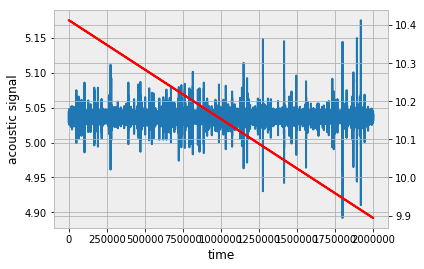

In [131]:
print(prediction[0:20,-1,0])
test = np.reshape(signal_test,(20000*100,1))*10
target = np.reshape(next_signal_test,(20000*100,1))*10
#pred = np.reshape(prediction[:,-1,:],(20000,1))*10

fig, ax1 = plt.subplots()
t = np.arange(len(test))
ax1.plot(t,test)
ax1.set_xlabel('time')
ax1.set_ylabel('acoustic signal')

ax2 = ax1.twinx()
ax2.plot(t,target, 'r')
#ax2.plot(pred, 'g')